(445901, 88)


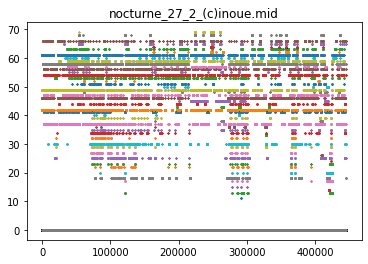

In [54]:
from mido import MidiFile
import string
import matplotlib.pyplot as plt
import numpy as np

def msg2dict(msg):
    result = dict()
    if 'note_on' in msg:
        on_ = True
    elif 'note_off' in msg:
        on_ = False
    else:
        on_ = None
    result['time'] = int(msg[msg.rfind('time'):].split(' ')[0].split('=')[1].translate(
        str.maketrans({a: None for a in string.punctuation})))

    if on_ is not None:
        for k in ['note', 'velocity']:
            result[k] = int(msg[msg.rfind(k):].split(' ')[0].split('=')[1].translate(
                str.maketrans({a: None for a in string.punctuation})))
    return [result, on_]

def switch_note(last_state, note, velocity, on_=True):
    # piano has 88 notes, corresponding to note id 21 to 108, any note out of this range will be ignored
    result = [0] * 88 if last_state is None else last_state.copy()
    if 21 <= note <= 108:
        result[note-21] = velocity if on_ else 0
    return result

def get_new_state(new_msg, last_state):
    new_msg, on_ = msg2dict(str(new_msg))
    new_state = switch_note(last_state, note=new_msg['note'], velocity=new_msg['velocity'], on_=on_) if on_ is not None else last_state
    return [new_state, new_msg['time']]

def track2seq(track):
    # piano has 88 notes, corresponding to note id 21 to 108, any note out of the id range will be ignored
    result = []
    last_state, last_time = get_new_state(str(track[0]), [0]*88)
    for i in range(1, len(track)):
        new_state, new_time = get_new_state(track[i], last_state)
        if new_time > 0:
            result += [last_state]*new_time
        last_state, last_time = new_state, new_time
        
    return result

def mid2arry(mid, min_msg_pct=0.2):
    tracks_len = [len(tr) for tr in mid.tracks]
    min_n_msg = max(tracks_len) * min_msg_pct
    # convert each track to nested list
    all_arys = []
    for i in range(len(mid.tracks)):
        if len(mid.tracks[i]) > min_n_msg:
            ary_i = track2seq(mid.tracks[i])
            all_arys.append(ary_i)
    # make all nested list the same length
    max_len = max([len(ary) for ary in all_arys])
    for i in range(len(all_arys)):
        if len(all_arys[i]) < max_len:
            all_arys[i] += [[0] * 88] * (max_len - len(all_arys[i]))
    all_arys = np.array(all_arys)
    all_arys = all_arys.max(axis=0)
    # trim: remove consecutive 0s in the beginning and at the end
    sums = all_arys.sum(axis=1)
    ends = np.where(sums > 0)[0]
    return all_arys[min(ends): max(ends)]

file = '../maestro-v3.0.0/2018/MIDI-Unprocessed_Chamber2_MID--AUDIO_10_R3_2018_wav--1.midi'
mid = MidiFile(file, clip=True)

result_array = mid2arry(mid)
print(result_array.shape)

plt.plot(range(result_array.shape[0]), np.multiply(np.where(result_array>0, 1, 0), range(1, 89)), marker='.', markersize=1, linestyle='')
plt.title("nocturne_27_2_(c)inoue.mid")
plt.show()


    





In [42]:
import mido

def arry2mid(ary, tempo=500000):
    # get the difference
    new_ary = np.concatenate([np.array([[0] * 88]), np.array(ary)], axis=0)
    changes = new_ary[1:] - new_ary[:-1]
    # create a midi file with an empty track
    mid_new = mido.MidiFile()
    track = mido.MidiTrack()
    mid_new.tracks.append(track)
    track.append(mido.MetaMessage('set_tempo', tempo=tempo, time=0))
    track.append(mido.MetaMessage('time_signature', numerator=4, denominator=4, clocks_per_click=24, notated_32nd_notes_per_beat=8, time=0))
    
    # add difference in the empty track
    last_time = 0
    for ch in changes:
        if set(ch) == {0}:  # no change
            last_time += 1
        else:
            on_notes = np.where(ch > 0)[0]
            on_notes_vol = ch[on_notes]
            off_notes = np.where(ch < 0)[0]
            first_ = True
            for n, v in zip(on_notes, on_notes_vol):
                new_time = last_time if first_ else 0
                track.append(mido.Message('note_on', note=n + 21, velocity=v, time=new_time))
                first_ = False
            for n in off_notes:
                new_time = last_time if first_ else 0
                track.append(mido.Message('note_off', note=n + 21, velocity=0, time=new_time))
                first_ = False
            last_time = 0
    return mid_new

mid_new = arry2mid(result_array, 500000)
mid_new.save('mid_new.mid')

In [17]:
#print(mid)

In [34]:
import pypianoroll
import numpy as np
file = '../maestro-v3.0.0/2018/MIDI-Unprocessed_Chamber2_MID--AUDIO_09_R3_2018_wav--1.midi'
multitrack = pypianoroll.read(file)
print(multitrack.resolution
    )
#multitrack.trim(0, multitrack.resolution)
track = multitrack.tracks[0]
track2 = track.pianoroll
rta = np.delete(np.delete(track2, range(109,128) , 1), range(21), 1)
print(rta.shape)
print(rta)


24
(27960, 88)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
mid2 = MidiFile('mid_new.mid', clip=True)
#print(mid2.tracks[0])
file = '../maestro-v3.0.0/2018/MIDI-Unprocessed_Chamber2_MID--AUDIO_09_R3_2018_wav--1.midi'
mid = MidiFile(file, clip=True)
def contar_ticks(track):
    rta = 0
    for x in track:
        rta+=x.time
    return rta
rta = contar_ticks(mid.tracks[1])
print(rta)

447166


In [ ]:
print(mid)

MidiFile(type=1, ticks_per_beat=384, tracks=[
  MidiTrack([
    MetaMessage('set_tempo', tempo=500000, time=0),
    MetaMessage('time_signature', numerator=4, denominator=4, clocks_per_click=24, notated_32nd_notes_per_beat=8, time=0),
    MetaMessage('end_of_track', time=1)]),
  MidiTrack([
    Message('program_change', channel=0, program=0, time=0),
    Message('control_change', channel=0, control=64, value=99, time=0),
    Message('control_change', channel=0, control=67, value=127, time=0),
    Message('control_change', channel=0, control=67, value=126, time=46),
    Message('control_change', channel=0, control=67, value=126, time=15),
    Message('control_change', channel=0, control=67, value=126, time=212),
    Message('control_change', channel=0, control=64, value=100, time=31),
    Message('note_on', channel=0, note=81, velocity=54, time=290),
    Message('note_on', channel=0, note=66, velocity=26, time=58),
    Message('note_on', channel=0, note=62, velocity=32, time=8),
    Mes